# Developing a constrained first-order algorithm to construct a portfolio using Intraday data

### In this project we develop an updated first-order algorithm to construct a portfolio using intraday data; with position bounds and using projected gradients.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### $\mathbf{Problem \ Statement}$

##### We will have data involving $n$ assets, and use the first $T$ days of the data to compute the portfolio.
##### The computation will produce a weight $x_i$ for each asset $i = 1,...,n$, which could be long or short.
##### We assume that on each day, a position is taken at the open, and closed at noon.  So we define:
$$ p^o_{j,t} = \ \text{price of asset $j$ on day $t$ at the open}$$
$$ p^1_{j,t} = \ \text{price of asset $j$ on day $t$ at noon}$$
$$ r_{j,t} =  \ \frac{p^1_{j,t} - p^o_{j,t}}{p^o_{j,t}} = \ \text{return earned by asset $j$ on day $t$.}$$
$$ \bar r_j = \ \frac{1}{T} \sum_{t = 1}^T r_{j,t} = \ \text{average return earned by asset $j$.}$$

The assets that we will use are: ABR, AMZN, GS, NFLX, NIO, NVDA, TSLA, UBS.

#### The optimization problem to solve depends on two parameters: $\theta \ge 0$ and $\pi > 0$.

$$ \text{minimize} \ \left(-\sum_{j = 1}^n \bar r_j x_j\right) \ + \ \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right)$$

$$ \text{subject to} \ |x_j| \le 1 \ \text{for all names $j$}$$


#### Your method should work with values of $T$ at least $100$.

#### Need to ensure our code works with $\pi = 2$ and $\pi = 4$.  For $\pi = 2$ use $\theta = 5$. 

#### Should be able to get meaningful problem behavior (i.e., nonzero portfolio).  And when $\pi = 4$ use $\theta = 1000$.
<br>

In [15]:
returns = pd.read_csv("Returns.csv")
returns

,Dates,ABR,AMZN,GS,NFLX,NIO,NVDA,TSLA,UBS
0,2021-02-01,-0.011845,0.015982,0.007047,0.008632,-0.047245,0.002927,0.016274,0.006194
1,2021-02-02,0.014195,-0.000326,0.017026,0.025070,-0.016053,0.002537,0.039364,0.006793
2,2021-02-03,0.001273,-0.006972,0.003241,-0.011761,0.043077,0.000468,-0.009874,0.002358
3,2021-02-04,0.034797,-0.001582,0.014105,-0.001935,-0.021403,-0.008533,-0.013258,0.005720
4,2021-02-05,-0.002571,0.004461,-0.005064,-0.003134,-0.020202,-0.005866,0.015920,-0.004330
...,...,...,...,...,...,...,...,...,...
106,2021-07-07,-0.000852,-0.004655,0.001377,-0.010433,-0.062784,-0.012048,-0.023799,-0.000901
107,2021-07-08,0.025225,0.004955,0.003137,0.000978,0.030331,0.010348,0.027443,0.002033
108,2021-07-09,0.020774,0.002678,0.011939,0.008598,-0.033952,-0.000439,-0.006081,0.006040
109,2021-07-12,0.002475,-0.011032,0.034291,-0.004737,-0.013590,0.005378,0.024046,0.015304


Objective Function:

$$ \text{minimize} \ \left(-\sum_{j = 1}^n \bar r_j x_j\right) \ + \ \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right)$$

Gradient of objective function:

$$   \left(-\sum_{j = 1}^n \bar r_j \right) \ + \ \frac{\theta \pi}{T} \left(  \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^{\pi - 1} \times \left( r_{j,t} -  \bar r_j \right) \right) $$

In [16]:
def evalFun( x , rbar , theta, T, pi, rt ):
    
    # First term of objective function - q1
    q1 = - np.sum( rbar * x )

    # Second term of objective function - q2
    inner_bracket = np.sum((rt-rbar) * x , axis=1)
    q2 = (theta/T) * np.sum(inner_bracket ** pi , axis=0)

    return q1 + q2  

def evalGrad(x, rbar, theta, T, pi, rt):

    # First term of gradient
    q1 = -rbar

    # Second term of gradient
    q2 = (theta * pi / T) * np.sum( (( (rt - rbar) * x ) ** (pi-1)).T @ (rt-rbar), axis=0)

    return q1 + q2

def run_grad_descent_momentum(x, rbar, theta, T, pi, rt, xsol, fvalsol, N,  mu, loudsteps):
        
        converged = False 
        olddeltas = np.empty_like(x)
        np.copyto(olddeltas, x)
        al = 0.01

        for iteration in range(N):

            np.copyto( xsol[iteration], x)
            
            fval = evalFun(x, rbar, theta, T, pi, rt)
            g_n = evalGrad(x, rbar, theta, T, pi, rt)
            g_n /= np.linalg.norm(g_n)
            
            # if loudsteps or 0 == iteration%50:
                # print('\nIteration', iteration)
                # print('at x = ({:.3e}, {:.3e}, {:.3e}) function value = {:.4e} and gradient = ({:.5e}, {:.5e}, {:.5e})'.format(x0,x1,x2,fval,g0, g1, g2))

            deltas = -g_n*mu + (1-mu)*olddeltas

            # Projected Gradient
            deltas[x >= 1] = np.minimum(0, deltas[x>=1])
            deltas[x <= -1] = np.maximum(0, deltas[x<=-1])

            newx = x + al*deltas

            # mag = np.linalg.norm(newx)
            # newx /= mag
            # newx /= np.sum(newx)

            np.copyto(olddeltas, deltas)

            ## Constraint on xj
            newx = np.minimum(1,newx)
            newx = np.maximum(-1,newx)

            newfval = evalFun(newx, rbar, theta, T, pi, rt)
            
            fvalsol[iteration] = newfval

            # if loudsteps or 0 == iteration%50:
                # print('at new solution x = ({:.4e},{:.4e}, {:.4e}) function takes value {:.4e}'.format(newx0,newx1,newx2,newfval))

            np.copyto(x, newx)

            al *= 0.98

            if abs(fval - newfval) < 1e-8:
                converged = True
                break 
                
        # print('\n*** Done at iteration {} and converged {} with final gradient ( {}, {}, {})\n'.format(iteration,converged, g0, g1, g2))
        return iteration, converged

Asset 1 : average return = 6.61e-04, variance = 1.81e-04
Asset 2 : average return = -3.34e-04, variance = 8.94e-05
Asset 3 : average return = 5.35e-04, variance = 1.27e-04
Asset 4 : average return = -2.97e-04, variance = 1.33e-04
Asset 5 : average return = -1.33e-03, variance = 1.13e-03
Asset 6 : average return = -5.08e-05, variance = 2.44e-04
Asset 7 : average return = -2.03e-03, variance = 5.25e-04
Asset 8 : average return = 9.65e-04, variance = 4.67e-05


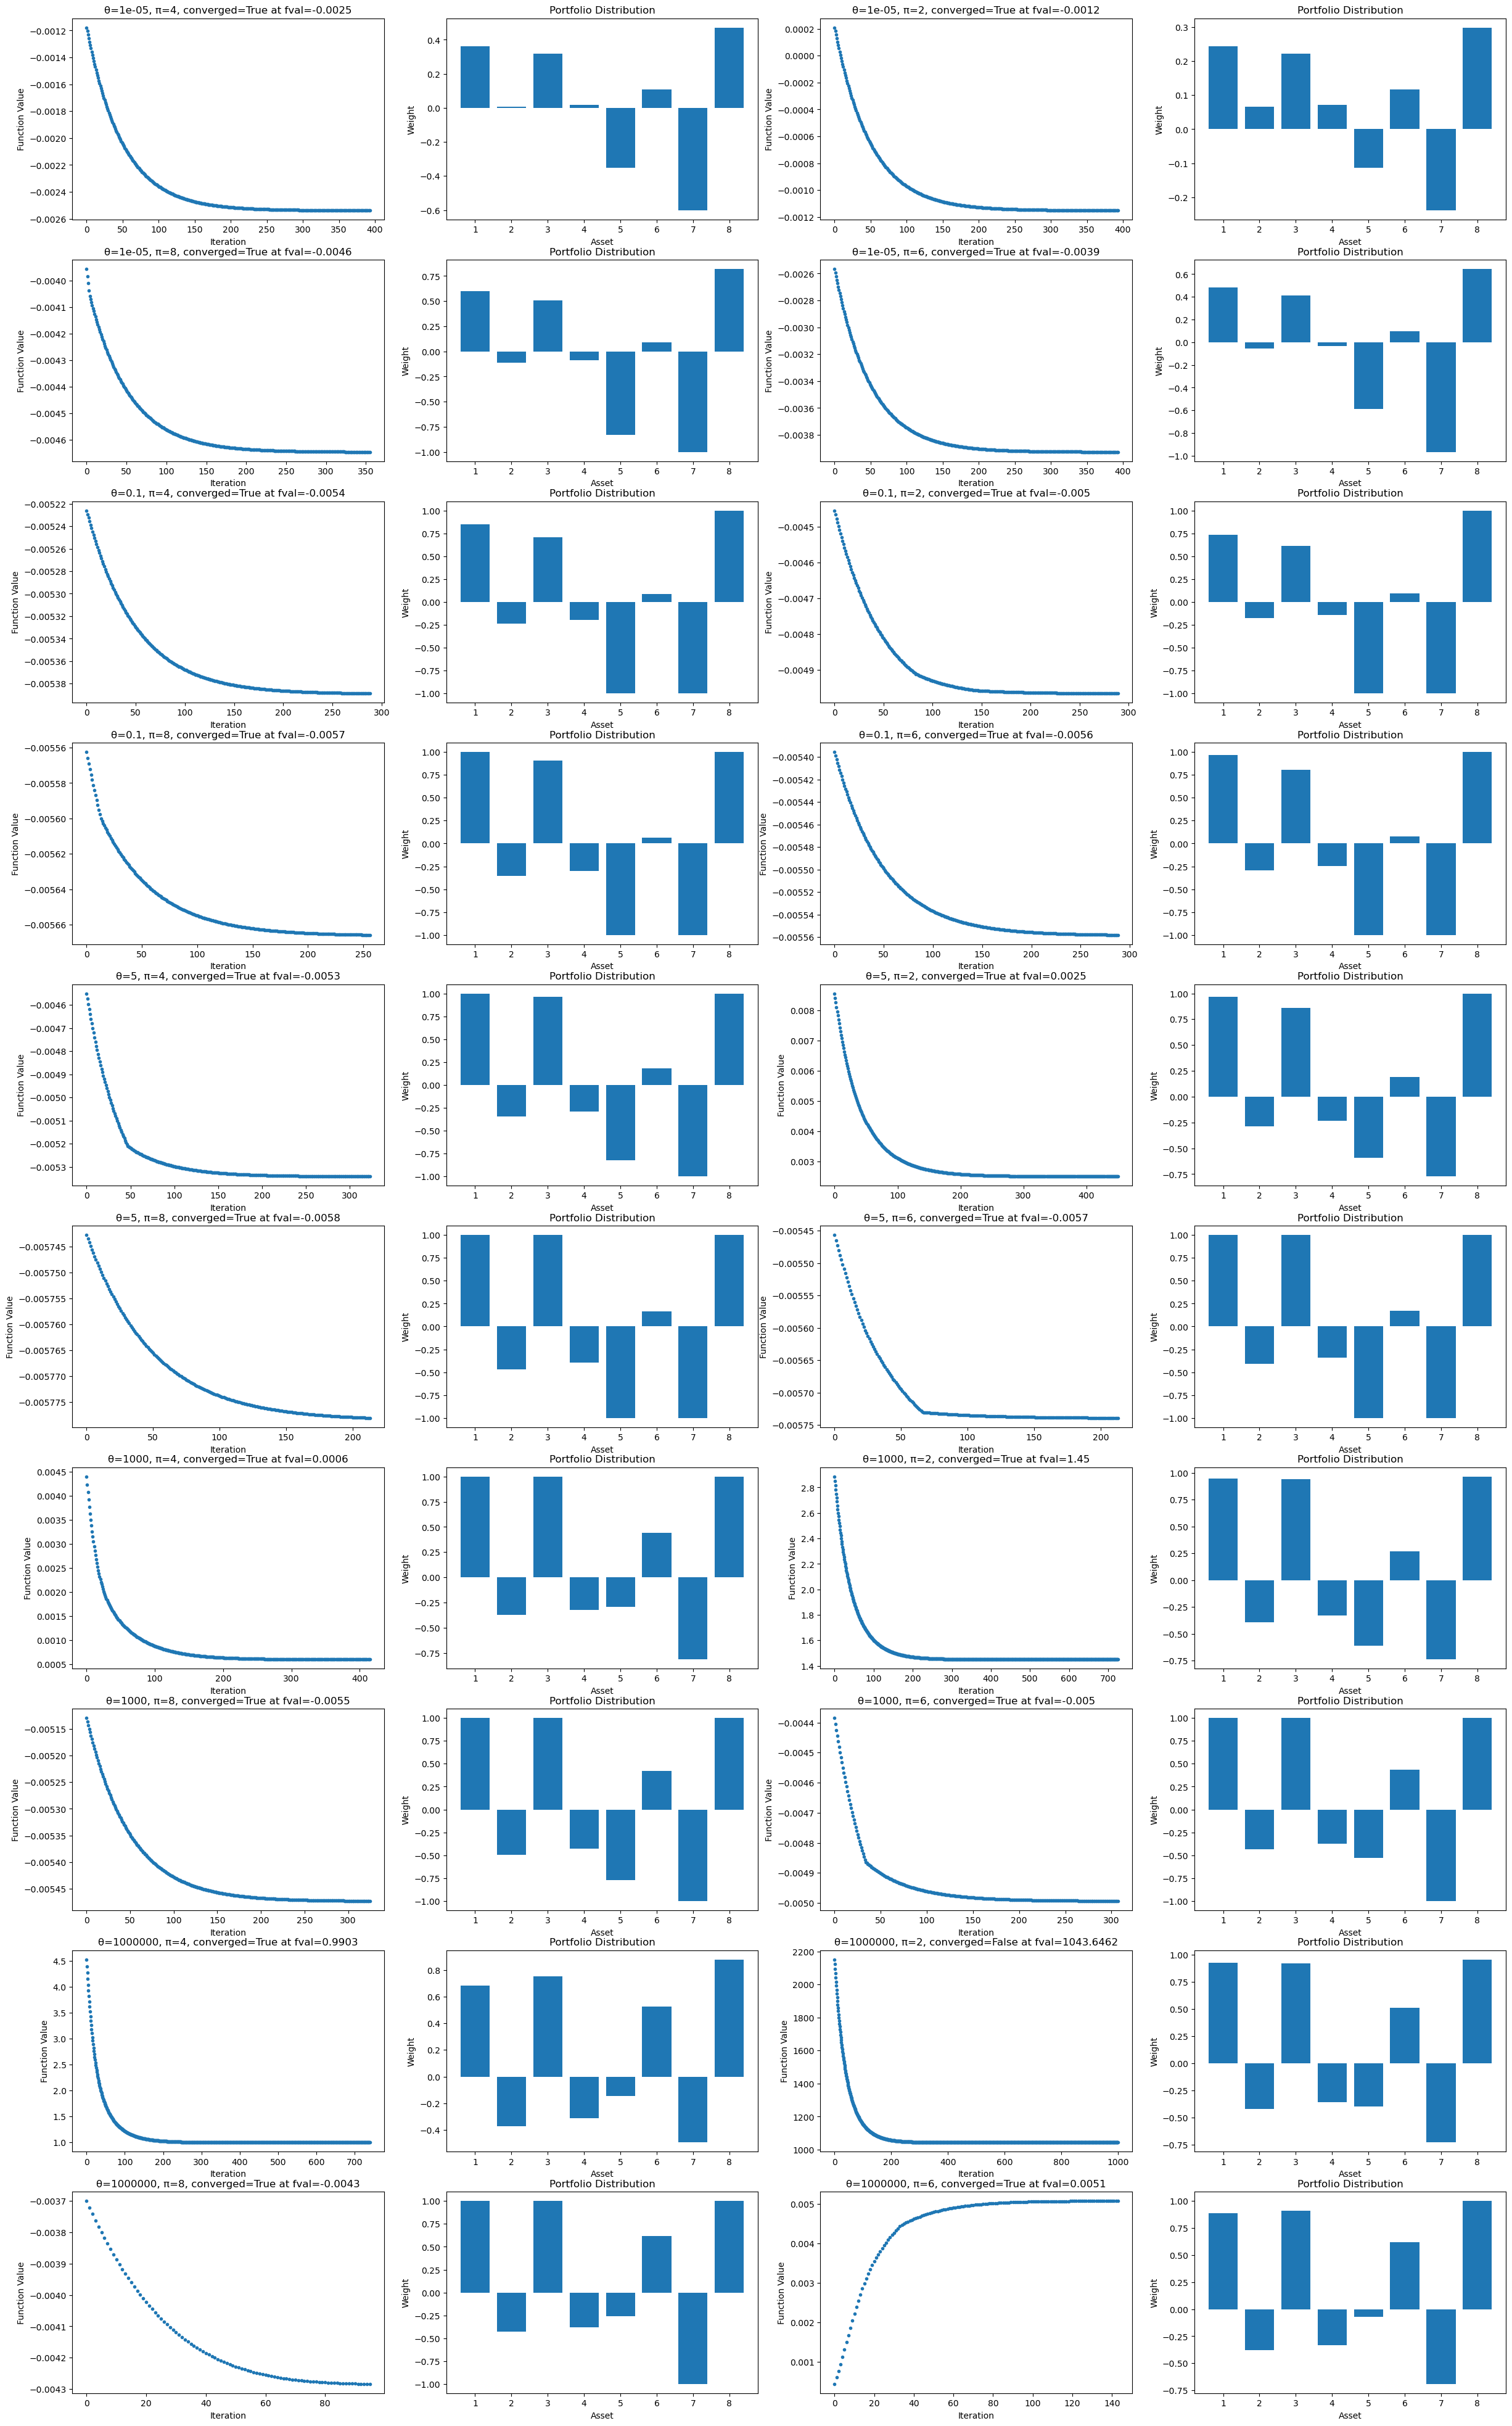

In [43]:
T = 100

n = returns.shape[1] - 1
x = np.array([1/n for _ in range(n)])

returns_array = np.array(returns.loc[:, returns.columns != "Dates"])

rt = returns_array[:T]
rbar = np.mean(rt, axis=0)

thetas = [0.00001, 0.1, 5, 1000, 10**6]
pis = [ 2, 4, 6, 8 ]

params = [{ "pi" : pi, "theta": theta } for theta in thetas for pi in pis ]
# params = [
    # {"pi" : 2 , "theta" : 5},
    # {"pi" : 4 , "theta" : 1000},
    # {"pi" : 2 , "theta" : 500},
    # {"pi" : 20 , "theta" : 5},
# ]

N = 1000

results = {}

asset_variances = np.var(rt, axis=0)

for i in range(n):
    print(f"Asset {i+1} : average return = {rbar[i]:.2e}, variance = {asset_variances[i]:.2e}")

fig, axes = plt.subplots(len(params)//2, 4, figsize=(30,50))

for i in range(len(params)):
    pi, theta = params[i]["pi"], params[i]["theta"]

    xsol = np.zeros((N, n))
    fvalsol = np.zeros(N)

    iteration , converged = run_grad_descent_momentum(x, rbar, theta, T, pi, rt, xsol, fvalsol, N, 0.9, False)

    results[(pi, theta)] = xsol[iteration]

    ax = axes[i//2,  (2 , 0) [i%2] ]

    # Plot convergence of function value against iteration
    ax.scatter(np.arange(0, iteration + 1), fvalsol[:iteration + 1], marker=".")
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Function Value')
    ax.set_title(f'\u03B8={theta}, \u03C0={pi}, converged={converged} at fval={round(fvalsol[iteration], 4)}')

    ax = axes[ i//2, (3 , 1) [i%2] ]

    # Plot portfolio created
    ax.bar(np.arange(1, n+1), xsol[iteration])
    ax.set_xlabel('Asset')
    ax.set_ylabel('Weight')
    ax.set_title('Portfolio Distribution')

# Additional Constraint


#### Suppose $x^*$ is the solution you compute above.  Next, solve the same optimization problem as above, except that you now have the constraint:
$$ \sum_j | x_j | \ \le \ 0.5*\sum_j |x^*_j |$$

Use a first-order barrier method for this!

### Re-writing the constraint as:

$$ \sum_j | x_j | \ \le \ target$$

### Modifying the objective function by adding barrier

$$ \text{minimize} \ \left(-\sum_{j = 1}^n \bar r_j x_j\right) \ + \ \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right) + B( target \ - \ \sum_j | x_j |   )$$

$$ \text{subject to} \ |x_j| \le 1 \ \text{for all names $j$}$$

$B(t) = - \lambda log(t)$ (logarithmic barrier)

In [10]:
def evalFun_barrier( x , rbar , theta, T, pi, rt, target, lambdaVal):
    
    q1 = - np.sum( rbar * x )
    inner_bracket = np.sum((rt-rbar) * x , axis=1)
    q2 = (theta/T) * np.sum(inner_bracket ** pi , axis=0)

    barrier = -lambdaVal * np.log( (target - np.sum( abs(x) )) )

    return q1 + q2 + barrier, barrier


def evalGrad_barrier(x, rbar, theta, T, pi, rt, target, lambdaVal):

    q1 = -rbar

    q2 = (theta * pi / T) * np.sum((( (rt - rbar) * x ) ** (pi-1)).T @ (rt-rbar), axis=0)

    barrier_grad =  lambdaVal / (target - np.sum( abs(x) ))

    return q1 + q2 + barrier_grad, barrier_grad


def run_grad_descent_momentum_barrier(x, rbar, theta, T, pi, rt, xsol, fvalsol, N,  mu, target, lambdaVal, loudsteps):
        
        converged = False 
        olddeltas = np.empty_like(x)
        np.copyto(olddeltas, x)
        al = 0.01

        count = 0

        for iteration in range(N):

            np.copyto( xsol[iteration], x)
            
            fval, barrier = evalFun_barrier(x, rbar, theta, T, pi, rt, target, lambdaVal)
            g_n, barrier_grad = evalGrad_barrier(x, rbar, theta, T, pi, rt, target, lambdaVal)
            g_n /= np.linalg.norm(g_n)
            
            # if loudsteps or 0 == iteration%50:
            #     print('\nIteration', iteration)
            #     print(f'at x = ({x}) function value = {fval} and gradient = ({g_n})')
            #     print('Barrier val - ', barrier)

            deltas = -g_n*mu + (1-mu)*olddeltas

            check_constr = x + al*deltas
            check_constr = np.sum(abs(check_constr))
            if check_constr >= target:
                 deltas *= 0

            newx = x + al*deltas

            # mag = np.linalg.norm(newx)
            # newx /= mag
            # newx /= sum(newx)

            np.copyto(olddeltas, deltas)

            newfval, barrier = evalFun_barrier(newx, rbar, theta, T, pi, rt, target, lambdaVal)
            
            fvalsol[iteration] = newfval

            # if loudsteps or 0 == iteration%50:
                # print('at new solution x = ({:.4e},{:.4e}, {:.4e}) function takes value {:.4e}'.format(newx0,newx1,newx2,newfval))

            np.copyto(x, newx)

            al *= 0.98

            if abs(fval - newfval) < 1e-20:
                if count > 10:
                    # print(fval, newfval)
                    converged = True
                    break 
                count += 1
                
        # print('\n*** Done at iteration {} and converged {} with final gradient ( {}, {}, {})\n'.format(iteration,converged, g0, g1, g2))
        return iteration, converged

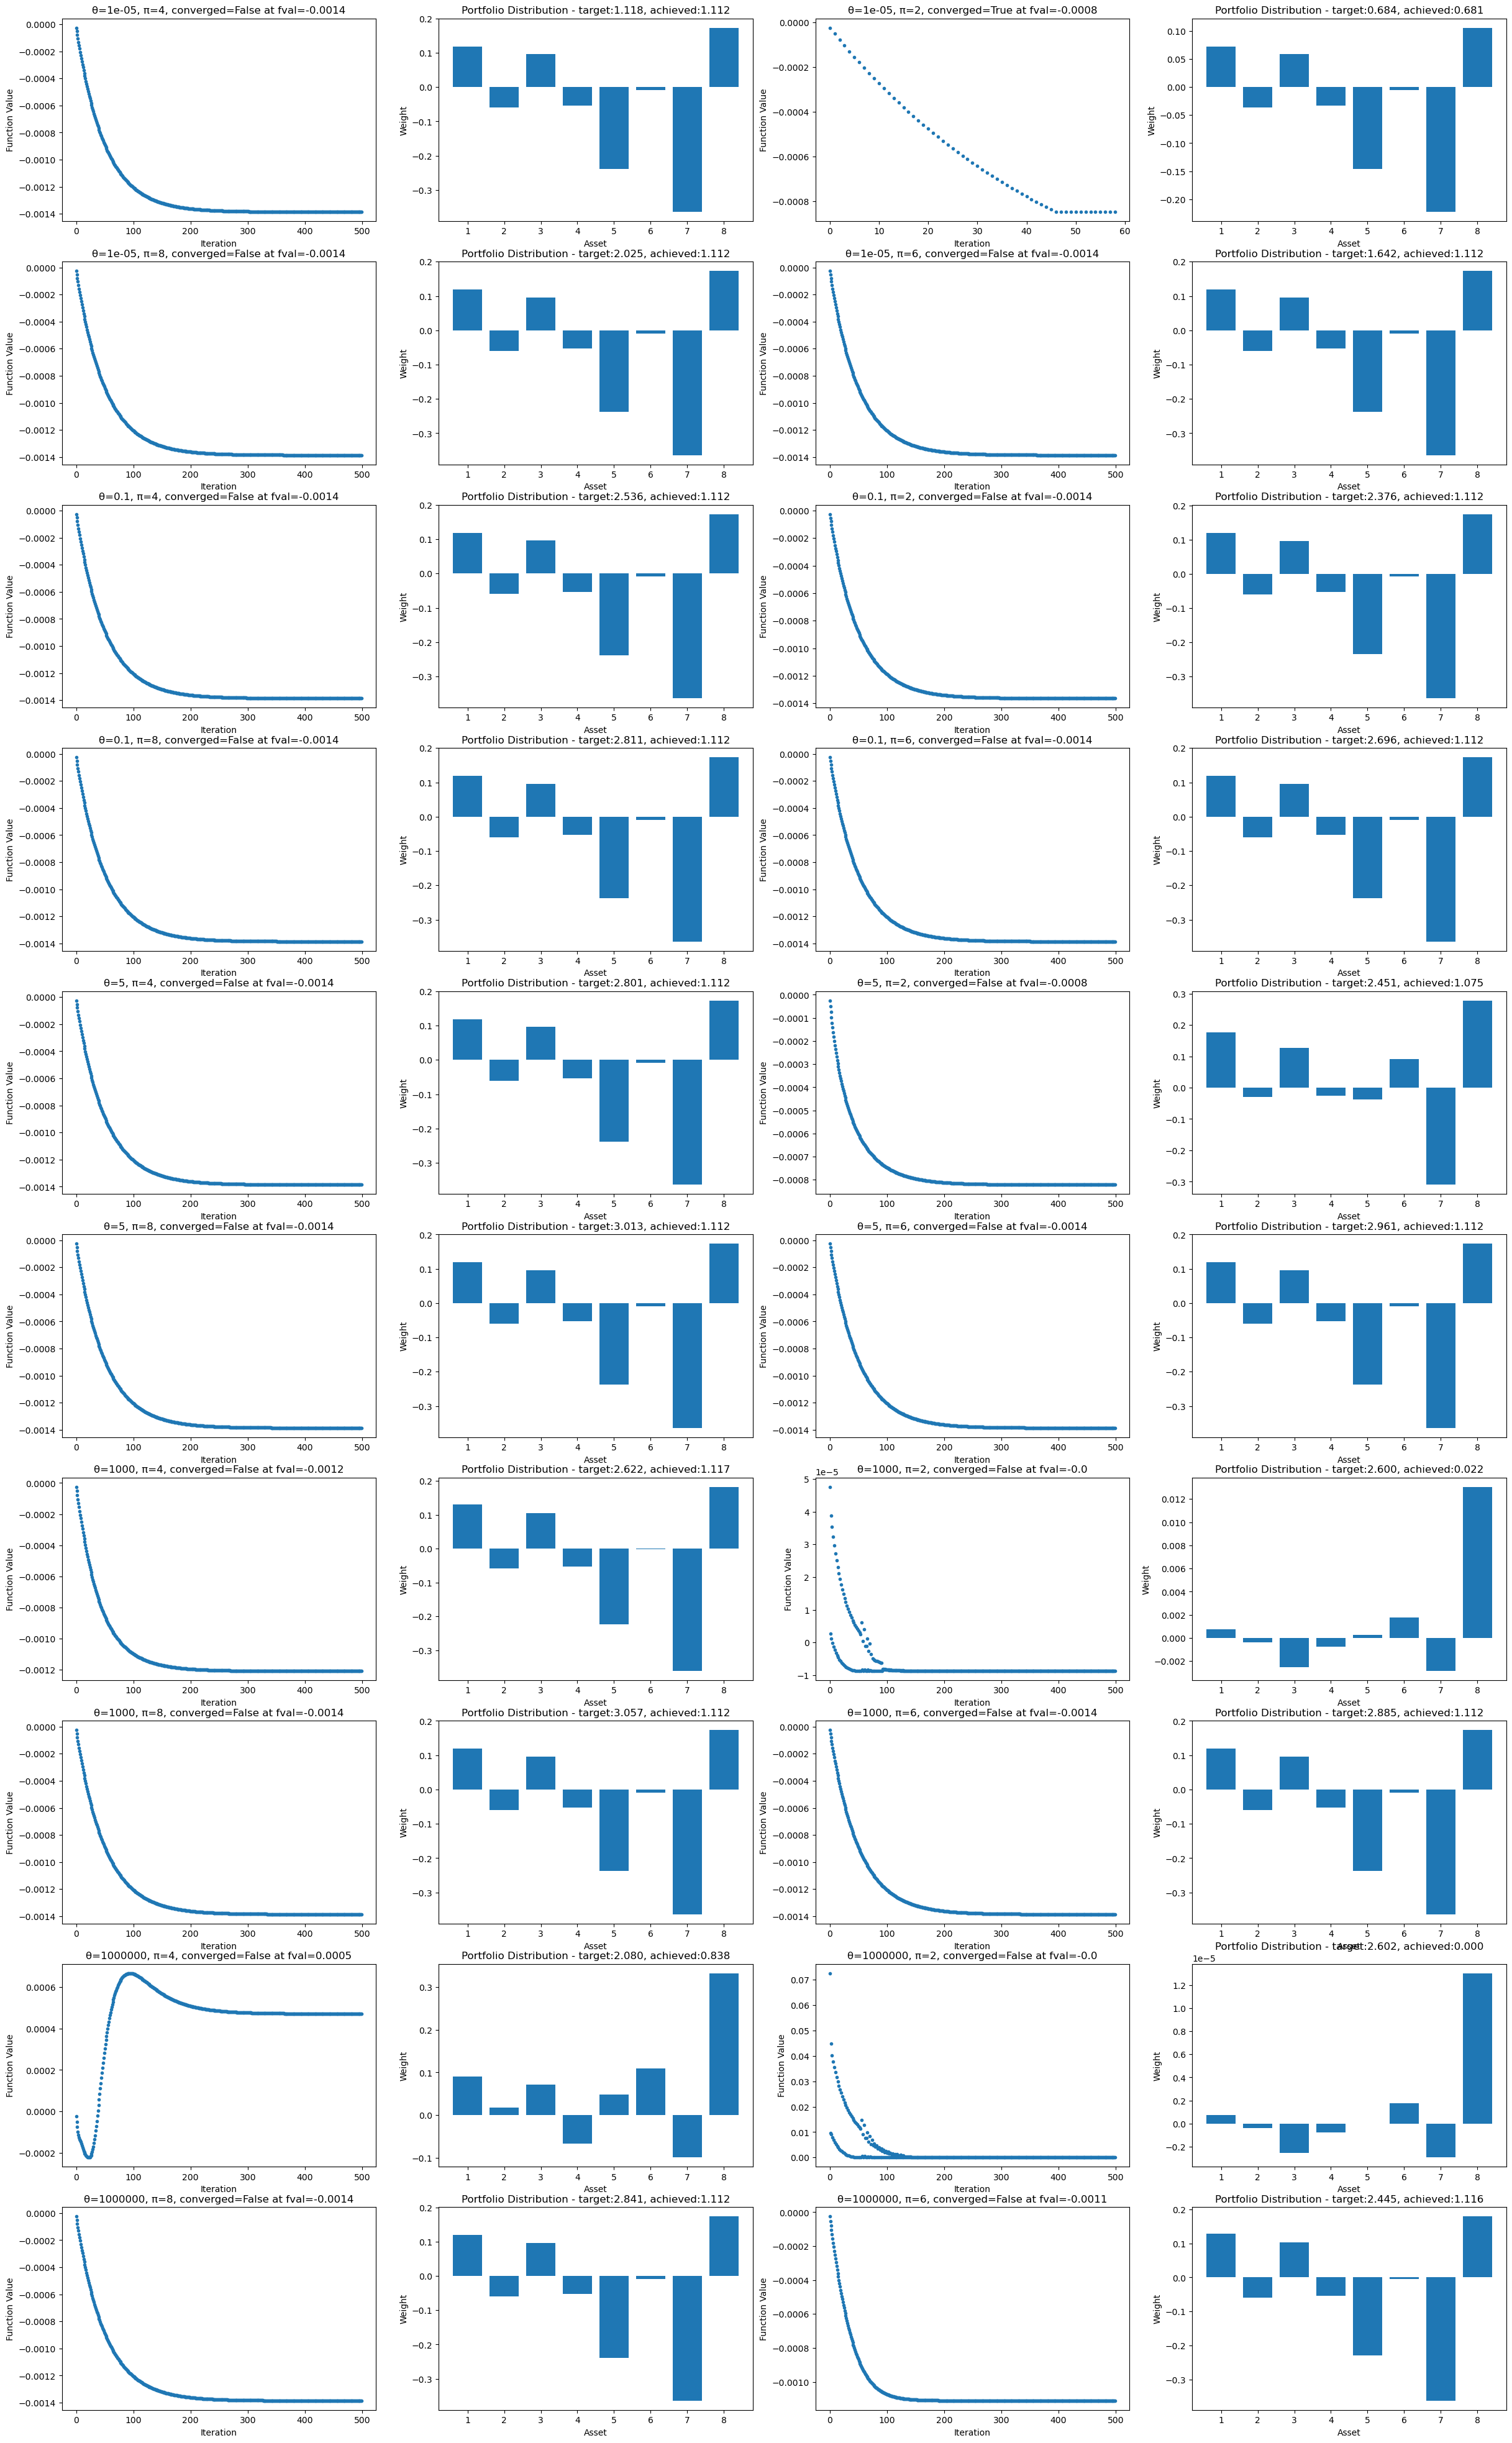

In [46]:
T = 100

n = returns.shape[1] - 1

returns_array = np.array(returns.loc[:, returns.columns != "Dates"])

rt = returns_array[:T]
rbar = np.mean(rt, axis=0)

N = 500

fig, axes = plt.subplots(len(params)//2, 4, figsize=(30,50))

for i in range(len(params)):
    pi, theta = params[i]["pi"], params[i]["theta"]

    x_star = results[(pi, theta)]
    target = 0.5 * np.sum(abs(x_star))

    x = np.array([0.0 for _ in range(n)])

    xsol = np.zeros((N, n))
    fvalsol = np.zeros(N)

    iteration , converged = run_grad_descent_momentum_barrier(x, rbar, theta, T, pi, rt, xsol, fvalsol, N, 0.9, target, 0.0000,  False)

    ax = axes[i//2,  (2 , 0) [i%2] ]
    # Plot convergence of function value against iteration
    ax.scatter(np.arange(0, iteration + 1), fvalsol[:iteration + 1], marker=".")
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Function Value')
    ax.set_title(f'\u03B8={theta}, \u03C0={pi}, converged={converged} at fval={round(fvalsol[iteration], 4)}')

    ax = axes[ i//2, (3 , 1) [i%2] ]
    # Plot portfolio created
    ax.bar(np.arange(1, n+1), xsol[iteration])
    ax.set_xlabel('Asset')
    ax.set_ylabel('Weight')
    ax.set_title(f'Portfolio Distribution - target:{target:.3f}, achieved:{np.sum(abs(xsol[iteration])):.3f}')

### <span style='color:red'>Benchmarking the portfolio on the remaining days</span>

#### On each of the remaining days, we proceed as follows. Denote by $x^*$ your portfolio. At the market open we invest $10^9 x^*_j$ on each asset $j$, and we close the position (by) noon.  You need to use the asset's price to compute the number of shares that you invest in, whether long or short. So the total you invest equals $$ \sum_{j = 1}^n 10^9 |x^*_j|.$$

#### Report the average return earned by your portfolio.

For theta=2, pi=1e-05 :
	 Returns made: 1104936.1149, --> 0.1105%
For theta=4, pi=1e-05 :
	 Returns made: 1155049.4566, --> 0.1155%
For theta=6, pi=1e-05 :
	 Returns made: 1186688.3028, --> 0.1187%
For theta=8, pi=1e-05 :
	 Returns made: 1208471.0857, --> 0.1208%
For theta=2, pi=0.1 :
	 Returns made: 1226736.6432, --> 0.1227%
For theta=4, pi=0.1 :
	 Returns made: 1238391.3296, --> 0.1238%
For theta=6, pi=0.1 :
	 Returns made: 1247607.4372, --> 0.1248%
For theta=8, pi=0.1 :
	 Returns made: 1168292.3707, --> 0.1168%
For theta=2, pi=5 :
	 Returns made: 1176603.4194, --> 0.1177%
For theta=4, pi=5 :
	 Returns made: 1100932.7952, --> 0.1101%
For theta=6, pi=5 :
	 Returns made: 1063234.1053, --> 0.1063%
For theta=8, pi=5 :
	 Returns made: 1067361.8781, --> 0.1067%
For theta=2, pi=1000 :
	 Returns made: 1071588.5009, --> 0.1072%
For theta=4, pi=1000 :
	 Returns made: 1061111.5395, --> 0.1061%
For theta=6, pi=1000 :
	 Returns made: 1065080.2116, --> 0.1065%
For theta=8, pi=1000 :
	 Returns made

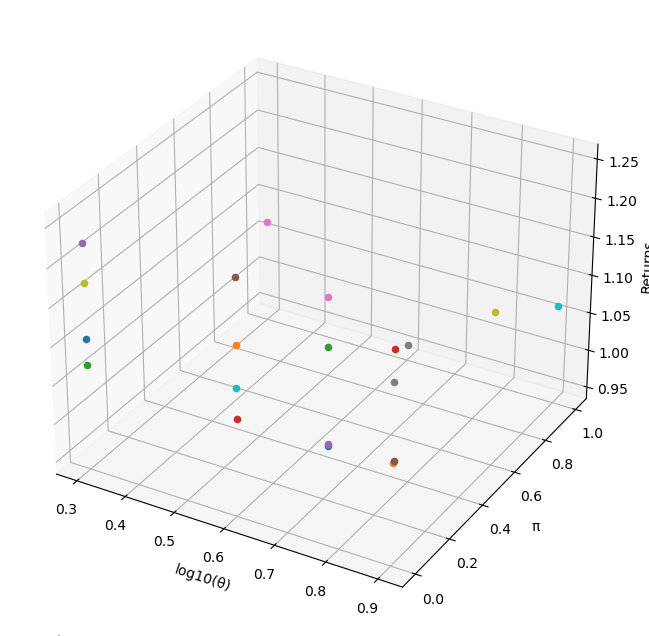

In [52]:
returns = pd.read_csv("./Returns.csv")
rt0, rt1, rt2 = returns['AMZN'].values, returns['NFLX'].values, returns['TSLA'].values
T = 100
remaining_days0, remaining_days1, remaining_days2 = rt0[T:], rt1[T:], rt2[T:]
r0, r1, r2 = np.mean(remaining_days0), np.mean(remaining_days1), np.mean(remaining_days2)

returns_obt = {}

fig2 = plt.figure( figsize=(8,8))
ax = fig2.add_subplot(111, projection='3d')

for result in results:
    x0=results[result][0]
    x1=results[result][1]
    x2=results[result][2]
    
    total = x0 + x1 + x2
    scaled_x0 = x0/total
    scaled_x1 = x1/total
    scaled_x2 = x2/total

    avg_return = 10**9 *( r0*scaled_x0 + r1*scaled_x1 + r2*scaled_x2)

    returns_obt[(result[0], result[1])] = avg_return

    print(f"For theta={result[0]}, pi={result[1]} :")
    print(f"\t Returns made: {avg_return:.4f}, --> {avg_return/(1e7):.4f}%")

    ax.scatter(np.log10(result[0]), result[1], avg_return, marker='o')

    ax.set_xlabel('log10(\u03B8)')
    ax.set_ylabel('\u03C0')
    ax.set_zlabel('Returns')

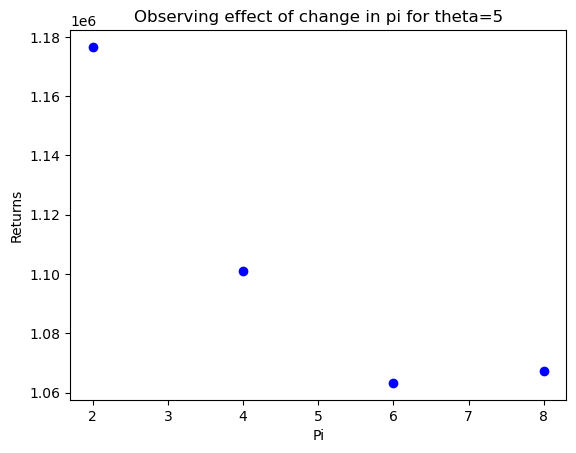

In [53]:
## Observing the change in returns due to change in pi for a fixed theta
## Fixing theta to 10

plt.figure()
plt.xlabel('Pi')
plt.ylabel('Returns')
plt.title('Observing effect of change in pi for theta=5')

for pi in pis:
    plt.scatter(pi , returns_obt[pi, 5], color='blue', marker='o')


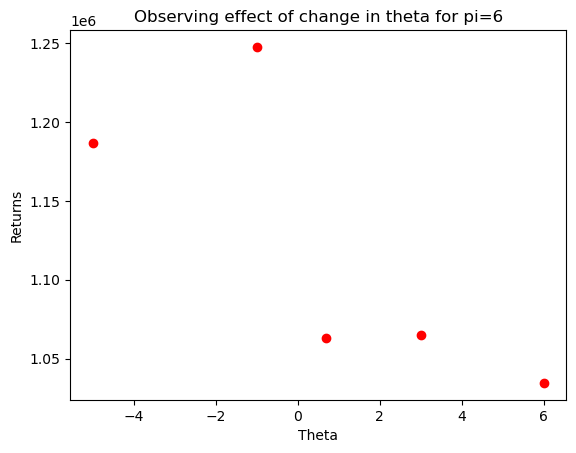

In [54]:
## Observing the change in returns due to change in theta for a fixed pi
## Fixing pi to 6

plt.figure()
plt.xlabel('Theta')
plt.ylabel('Returns')
plt.title('Observing effect of change in theta for pi=6')

for theta in thetas:
    plt.scatter(np.log10(theta), returns_obt[6, theta], color='red', marker='o')
